## 4. Data Modeling

### Import neccessary libraries

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from typing import List, Dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve

Read and prepare the dataset for modeling

In [21]:
processed_df = pd.read_csv('data/processed_data.csv')
y = processed_df['metacritic']
X = processed_df.drop(columns=['appid', 'name', 'metacritic'])

# Handle any missing values in X or y
X = X.dropna()
y = y.loc[X.index]

# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Apply standard scaling to all numerical features

In [22]:
scaler = StandardScaler()
numerical_cols = ['userscore', 'median_playtime', 'ccu', 'price', 'languages']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

Linear Regression Model


In [23]:
# Calculate Normalized MSE for evaluations
def calculate_nmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    nmse = mse / np.var(y_true)
    return nmse

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

# Evaluate the model
nmse_train_lr = calculate_nmse(y_train, y_pred_train_lr)
nmse_test_lr = calculate_nmse(y_test, y_pred_test_lr)
r2_train_lr = r2_score(y_train, y_pred_train_lr)
r2_test_lr = r2_score(y_test, y_pred_test_lr)

print(f"Training NMSE: {nmse_train_lr:.2f}, R2: {r2_train_lr:.2f}")
print(f"Testing NMSE: {nmse_test_lr:.2f}, R2: {r2_test_lr:.2f}")


Training NMSE: 0.58, R2: 0.42
Testing NMSE: 0.65, R2: 0.35


Decision Tree Regressor

In [24]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

# Evaluate the model
nmse_train_dt = calculate_nmse(y_train, y_pred_train_dt)
nmse_test_dt = calculate_nmse(y_test, y_pred_test_dt)
r2_train_dt = r2_score(y_train, y_pred_train_dt)
r2_test_dt = r2_score(y_test, y_pred_test_dt)

print(f"Training NMSE: {nmse_train_dt:.2f}, R2: {r2_train_dt:.2f}")
print(f"Testing NMSE: {nmse_test_dt:.2f}, R2: {r2_test_dt:.2f}")


Training NMSE: 0.00, R2: 1.00
Testing NMSE: 1.33, R2: -0.33


Random Forest Regressor


In [25]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluate the model 
nmse_train_rf = calculate_nmse(y_train, y_pred_train_rf)
nmse_test_rf = calculate_nmse(y_test, y_pred_test_rf) 
r2_train_rf = r2_score(y_train, y_pred_train_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print(f"Random Forest - Training NMSE: {nmse_train_rf:.2f}, R2: {r2_train_rf:.2f}")
print(f"Random Forest - Testing NMSE: {nmse_test_rf:.2f}, R2: {r2_test_rf:.2f}")

Random Forest - Training NMSE: 0.08, R2: 0.92
Random Forest - Testing NMSE: 0.66, R2: 0.34


Visualize learning curve for all three models 

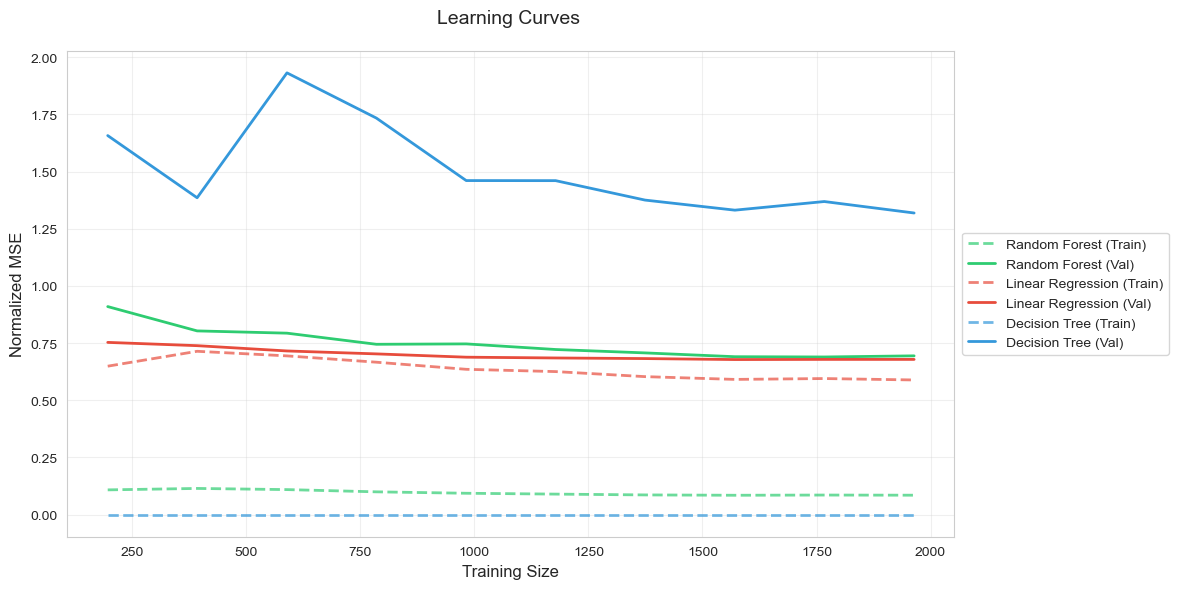

In [26]:
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

# Create custom NMSE scorer
def nmse_scorer(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse / np.var(y_true)  # Normalize by variance of true values

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
colors = ['#2ecc71', '#e74c3c', '#3498db'] 

# Calculate and plot learning curves for each model
for idx, (name, model) in enumerate(models.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        scoring=make_scorer(nmse_scorer),  # custom NMSE scorer
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),  # More points for smoother curves
    )
    
    # Calculate means and standard deviations
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    
    # Plot with better styling
    plt.plot(train_sizes, train_scores_mean, '--', color=colors[idx], 
             alpha=0.7, linewidth=2, label=f'{name} (Train)')
    plt.plot(train_sizes, test_scores_mean, '-', color=colors[idx], 
             linewidth=2, label=f'{name} (Val)')

# Improve plot appearance
plt.xlabel('Training Size', fontsize=12)
plt.ylabel('Normalized MSE', fontsize=12)
plt.title('Learning Curves ', fontsize=14, pad=20)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Set y-axis limits if needed
# plt.ylim(0, 1)  # Uncomment and adjust as needed

plt.show()

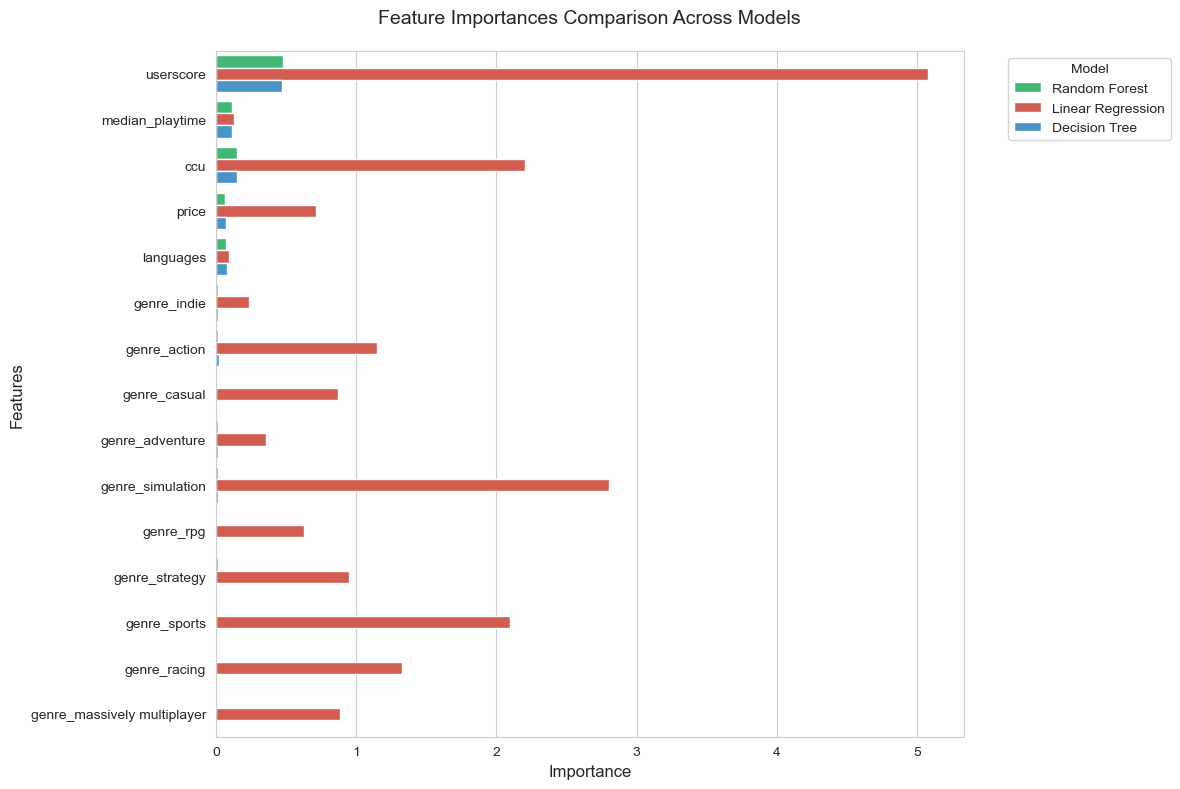

In [27]:
# Get feature importances for all models
def get_feature_importance(model, model_name, feature_names):
    if model_name == 'Linear Regression':
        # For linear regression, use absolute coefficients
        importances = np.abs(model.coef_)
    else:
        # For tree-based models, use feature_importances_
        importances = model.feature_importances_
    
    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Model': model_name
    })

# Create DataFrames for each model
feature_names = X_train.columns
importance_dfs = []

for name, model in models.items():
    model.fit(X_train, y_train)  # Fit each model if not already fitted
    importance_df = get_feature_importance(model, name, feature_names)
    importance_dfs.append(importance_df)

# Combine all feature importances
all_importances = pd.concat(importance_dfs, axis=0)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=all_importances,
    x='Importance',
    y='Feature',
    hue='Model',
    palette=['#2ecc71', '#e74c3c', '#3498db']
)

# Customize the plot
plt.title('Feature Importances Comparison Across Models', fontsize=14, pad=20)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Adjust legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

### Modeling results
Linear Regression have high NMSE on both train and test set -> Underfitting. The model also overestimate the importance of genres.

Decision Tree Regressor is perfectly fitting the training data, but perform very poorly on test set -> Overfitting. This suggests there are still noise in the data.

Random Forest Regressor fits the training data reasonably, but also do not generalize well to the testing data.

### Conclusion:
We can still improve the model by adding more data and tuning the hyperparameters.

Plan: 
- Add feature "Age", double the dataset. 
- Evaluate Linear Regression without genres. 
- Figure out how to remove noise.
- Adding more advanced models.